# Getting PyLadies chapter information.
PyLadies has many chapters listed on its webpage `https://www.pyladies.com/locations`. I would like to do some analytics to understand how each chapter interacts with its members.

## Download requirements.
I will use the API provided by Meetup, which I install via the following:
``` shell
pip install meetup-api
```

## Import relevant packages.

In [192]:
import requests
import random
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from datetime import datetime
import meetup.api
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline

In [228]:
font = {'family' : 'sans-serif',
        'size'   : 16}

matplotlib.rc('font', **font)

## Scrape the PyLadies website for chapters and social media links.

In [12]:
pyladies_request = requests.get('https://www.pyladies.com/locations')
pyladies_soup = BeautifulSoup(pyladies_request.text, 'html.parser')

In [13]:
all_chapters = pyladies_soup.find_all(class_="chapter_location")
print('There are {} PyLadies chapters listed on the PyLadies website'.format(len(all_chapters)))

There are 84 PyLadies chapters listed on the PyLadies website


#### Determine social media links.

For a given chapter, we can access the information on the website by looking at the html code:

In [45]:
ix = 5
single_chapter = all_chapters[ix]
single_chapter

<div class="chapter_location" data-chapter-name="Australia" data-meetup-id="">
<div class="logo-container">
<img alt="Australia" src="../assets/images/pyladies_australia.png"/>
</div>
<h3 class="chpts chapter-name">
<a href="/locations/http://australia.pyladies.com/">
                            
                            Australia</a>
</h3>
<h3 class="chpts social-icons">
<a class="social icon link" data-icon="🔗" href="http://australia.pyladies.com/" title="Website"></a>
<a class="social icon vcard" data-icon="" href="/cdn-cgi/l/email-protection#701105030402111c19113000091c11141915035e131f1d" title="Contact"></a>
<a class="social icon facebook" data-icon="" href="https://www.facebook.com/pyladiesau" title"facebook"=""></a>
<a class="social icon github" data-icon="" href="https://github.com/PyLadiesAU" title"github"=""></a>
<a class="social icon twitter" data-icon="" href="https://twitter.com/pyladiesau" title="Twitter"></a>
</h3>
</div>

Lets look at the social media links for a given chapter:

In [64]:
social_links = single_chapter.find_all('a', attrs={"class":"social"})
social_links

[<a class="social icon vcard" data-icon="" href="/cdn-cgi/l/email-protection#e993889b8088a9999085888d808c9ac78a8684" title="Contact"></a>]

In [68]:
social_platforms = set([])
bad_links = []
for single_chapter in all_chapters:
    social_links = single_chapter.find_all('a', attrs={"class":"social"})
    for social_link in social_links:
        if social_link.has_attr("title"):
            social_platforms.add(social_link['title'])
        else:
            bad_links.append(social_link)
print(f'The social platforms found: {social_platforms}\n')
print(f'There were {len(bad_links)} links without a title attribute. A sample bad link is: \n{random.choice(bad_links)}')

The social platforms found: {'Twitter', 'Website', 'Timepad Link', 'Contact', 'Meetup Link'}

There were 52 links without a title attribute. A sample bad link is: 
<a class="social icon google-plus" data-icon="" href="https://plus.google.com/u/0/communities/113677670074162908256" title"google+"=""></a>


Here is where I noticed that the `title` attribute for social media links corresponding to Facebook, Google+, and Github had syntax errors. I created a Pull Request for the PyLadies website to fix this:

```html 
<!-- BEFORE -->
<a class="social icon github" title"github"=""></a>

<!-- AFTER -->
<a class="social icon github" title="github"></a>
```

While the HTML code is getting fixed, we can access the social link by the `class` attribute.

In [94]:
social_link.attrs

{'class': ['social', 'icon', 'vcard'],
 'data-icon': '\ue722',
 'href': '/cdn-cgi/l/email-protection#e993889b8088a9999085888d808c9ac78a8684',
 'title': 'Contact'}

In [74]:
social_link['class'][-1]

'vcard'

In [78]:
social_platforms = set([])
for single_chapter in all_chapters:
    social_links = single_chapter.find_all('a', attrs={"class":"social"})
    for social_link in social_links:
        social_platforms.add(social_link['class'][-1])
print(f'The social platforms found: {social_platforms}')

The social platforms found: {'twitter', 'link', 'vcard', 'github', 'facebook', 'google-plus', 'location'}


Note that for class description: 
- `link = website link` 
- `location = Meetup Link`, expect when `location = Timepad Link` for PyLadies St. Petersburg.

In [132]:
social_platforms = set([])
bad_links = []
for single_chapter in all_chapters:
    social_links = single_chapter.find_all('a', attrs={"class":"social"})
    for social_link in social_links:
        if social_link.has_attr("title"):
            social_platforms.add(social_link['title'])
        else:
            social_platforms.add(social_link['class'][-1])
print(f'The social platforms found: \n{social_platforms}')

The social platforms found: 
{'Twitter', 'Website', 'Timepad Link', 'Contact', 'github', 'facebook', 'Meetup Link', 'google-plus'}


In [193]:
chapter_info = pd.DataFrame(columns=social_platforms)

for chapter_id, single_chapter in enumerate(all_chapters):
    chapter_dict = {}
    social_links = single_chapter.find_all('a', attrs={"class":"social"})
    chapter_dict['chapter_id'] = chapter_id
    chapter_name = single_chapter.find("h3", class_="chpts chapter-name").find("a").text.strip()
    chapter_dict['chapter_name'] = chapter_name
    for social_link in social_links:
        if social_link.has_attr("title"):
            chapter_dict[social_link['title']] = social_link['href']
        else:
            chapter_dict[social_link['class'][-1]] = social_link['href']
    chapter_info = chapter_info.append(chapter_dict, ignore_index=True)
    
chapter_info['chapter_id'] = chapter_info['chapter_id'].astype('int')
chapter_info = chapter_info.set_index(['chapter_id', 'chapter_name'])
chapter_info.head()

,,Twitter,Website,Timepad Link,Contact,github,facebook,Meetup Link,google-plus
chapter_id,chapter_name,,,,,,,,
0,"Amsterdam, the Netherlands",https://twitter.com/PyLadiesAMS,amsterdam,NaN,/cdn-cgi/l/email-protection#751418060110071114...,NaN,NaN,http://www.meetup.com/PyLadiesAMS/,NaN
1,"Antananarivo, MDG",https://twitter.com/PyladiesMDG,tnr,NaN,/cdn-cgi/l/email-protection#0e7a607c4e7e77626f...,NaN,NaN,NaN,NaN
2,"Aracati, Brazil",https://twitter.com/PyladiesAracati,NaN,NaN,/cdn-cgi/l/email-protection#563724373537223f16...,NaN,NaN,http://www.meetup.com/PyladeisAracati/,NaN
3,"Atlanta, GA",https://twitter.com/pyladiesATL,atl,NaN,/cdn-cgi/l/email-protection#09687d654979706568...,NaN,NaN,http://www.meetup.com/pyladiesATL/,NaN
4,"Austin, TX",https://twitter.com/pyladiesATX,atx,NaN,/cdn-cgi/l/email-protection#0e6f7a764e7e77626f...,NaN,NaN,http://www.meetup.com/pyladies-atx/,NaN


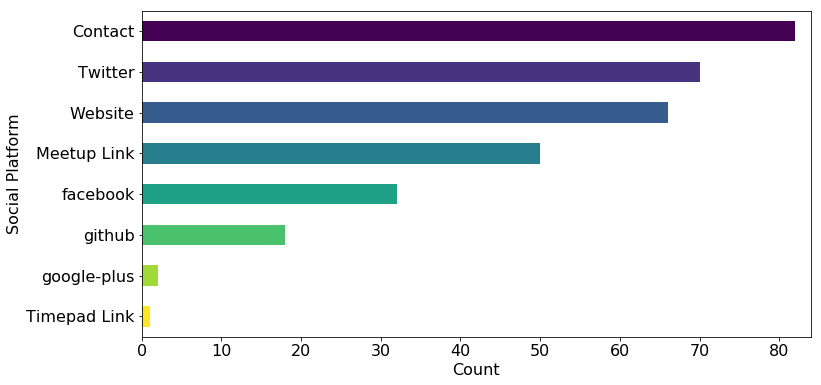

In [229]:
fig, ax = plt.subplots(figsize=(12, 6))
color = matplotlib.cm.viridis_r(np.linspace(0, 1, len(chapter_info.columns)))
chapter_info.count().sort_values().plot(kind='barh', ax=ax, color=color);
ax.set_xlim(xmax=chapter_info.index.get_level_values(level='chapter_id').max()+1);
ax.set_ylabel('Social Platform') ; ax.set_xlabel('Count');

In [538]:
chapter_info.to_csv('chapter_info.gz', compression='gzip')

## Meetup.
I will be working with the Meetup API. To get your own API key, just go to the [Meetup API Website](https://www.meetup.com/meetup_api/)

In [539]:
client = meetup.api.Client()
client.api_key = 'insert-your-key-here'

In [363]:
chapter_meetups = chapter_info[['Meetup Link']]
chapter_meetups.head()

,,Meetup Link
chapter_id,chapter_name,
0,"Amsterdam, the Netherlands",http://www.meetup.com/PyLadiesAMS/
1,"Antananarivo, MDG",NaN
2,"Aracati, Brazil",http://www.meetup.com/PyladeisAracati/
3,"Atlanta, GA",http://www.meetup.com/pyladiesATL/
4,"Austin, TX",http://www.meetup.com/pyladies-atx/


In [364]:
meetup_api_cols = ['meetup_name', 'group_id', 'status', 'meetup_members', 
                   'country', 'state', 'city', 'timezone', 'longitude', 'latitude', 
                   'num_future', 'num_past', 'num_past_scraped', 'next_meetup', 'last_meetup', 'last_meetup_rsvp']

In [365]:
chapter_meetups = pd.concat([chapter_meetups, pd.DataFrame(columns=meetup_api_cols)], sort=False)

In [366]:
chapter_meetups.columns

Index(['Meetup Link', 'meetup_name', 'group_id', 'status', 'meetup_members',
       'country', 'state', 'city', 'timezone', 'longitude', 'latitude',
       'num_future', 'num_past', 'num_past_scraped', 'next_meetup',
       'last_meetup', 'last_meetup_rsvp'],
      dtype='object')

In [367]:
chapter_meetups.head()

,,Meetup Link,meetup_name,group_id,status,meetup_members,country,state,city,timezone,longitude,latitude,num_future,num_past,num_past_scraped,next_meetup,last_meetup,last_meetup_rsvp
chapter_id,chapter_name,,,,,,,,,,,,,,,,,
0,"Amsterdam, the Netherlands",http://www.meetup.com/PyLadiesAMS/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Antananarivo, MDG",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Aracati, Brazil",http://www.meetup.com/PyladeisAracati/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Atlanta, GA",http://www.meetup.com/pyladiesATL/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Austin, TX",http://www.meetup.com/pyladies-atx/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for ix, row in chapter_meetups.iterrows():
    
    meetup_url = row['Meetup Link']
    if not pd.isnull(meetup_url):
        row_request = requests.get(meetup_url)
        if row_request.status_code != 200:
            pass
        else:
            
            print(meetup_url)
            
            ## Get the Meetup Group details.
            group_info = client.GetGroup({'urlname': meetup_url.split('meetup.com/')[1]})
            
            ## Get all future and past events.
            future_activity = client.GetEvents(group_id = group_info.id)
            past_activity = client.GetEvents(group_id = group_info.id, status='past')

            num_future = future_activity.meta['total_count']            
            num_past = past_activity.meta['total_count']

            ## I found that the number of past events wasn't always accurate with the API, so I also find it using web scraping.
            row_soup = BeautifulSoup(row_request.text, 'html.parser')
            events = row_soup.find_all(class_="text--sectionTitle text--bold padding--bottom")
            num_past_scraped = int([f for f in events if "Past" in str(f)][0].text.split('(')[1].split(')')[0])
            
            if num_future > 0:
                next_date = datetime.fromtimestamp(future_activity.results[0]['time']/1000.0)  
            else:
                next_date = np.nan
                
            if num_past == 0 and num_past_scraped != 0: 
                last_date = datetime.fromtimestamp(int(row_soup.find_all("time", class_="")[0]['datetime'])/1000.0) 
                yes_rsvp = int(row_soup.find_all("li", class_="avatarRow--attendingCount display--inline text--small text--secondary")[0].text.split(' ')[0])
            elif num_past > 0:
                last_date = datetime.fromtimestamp(past_activity.results[-1]['time']/1000.0)
                yes_rsvp = past_activity.results[-1]['yes_rsvp_count']
            else: 
                last_date = np.nan
                yes_rsvp = np.nan 
                
            chapter_meetups.loc[ix, meetup_api_cols] = [group_info.name, group_info.id, group_info.status, group_info.members,
                                                        group_info.country, group_info.state, group_info.city, group_info.timezone, 
                                                        group_info.lon, group_info.lat,
                                                        num_future, num_past, num_past_scraped, next_date, last_date, yes_rsvp]

In [565]:
chapter_meetups.to_csv('chapter_meetups.gz', compression='gzip')

In [548]:
chapter_meetups.dropna(subset=['Meetup Link'])

,,Meetup Link,meetup_name,group_id,status,meetup_members,country,state,city,timezone,longitude,latitude,num_future,num_past,num_past_scraped,next_meetup,last_meetup,last_meetup_rsvp
chapter_id,chapter_name,,,,,,,,,,,,,,,,,
0,"Amsterdam, the Netherlands",http://www.meetup.com/PyLadiesAMS/,PyLadies Amsterdam,9301202,active,298,NL,,Amsterdam,Europe/Amsterdam,4.89,52.37,0,13,13,NaN,2015-12-10 12:00:00,18
2,"Aracati, Brazil",http://www.meetup.com/PyladeisAracati/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Atlanta, GA",http://www.meetup.com/pyladiesATL/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Austin, TX",http://www.meetup.com/pyladies-atx/,PyLadies ATX,5947662,active,1023,US,TX,Austin,US/Central,-97.76,30.24,12,185,187,2018-11-19 20:00:00,2018-10-30 19:30:00,19
6,"Bangalore, India",http://www.meetup.com/PyladiesBangalore/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"Belo Horizonte, Brazil",http://www.meetup.com/PyLadies-BH-Meetup/,PyLadies BH Meetup,18890724,active,190,BR,,Belo Horizonte,America/Sao_Paulo,-43.94,-19.92,0,2,2,NaN,2016-05-21 13:00:00,11
10,"Berlin, Germany",http://www.meetup.com/PyLadies-Berlin/,PyLadies Berlin,8623152,active,1146,DE,,Berlin,Europe/Berlin,13.38,52.52,2,65,66,2018-11-13 13:00:00,2018-10-27 04:00:00,4
13,"Boston, MA",http://www.meetup.com/PyLadies-Boston/,PyLadies Boston,8401402,active,1253,US,MA,Boston,US/Eastern,-71.06,42.36,0,0,199,NaN,2018-09-27 18:00:00,17
16,"Brno, Czech Republic",http://www.meetup.com/pyladiescz/,PyWorking Sessions - Praha,5160912,active,301,CZ,,Prague,Europe/Prague,14.43,50.08,3,45,46,2018-11-19 12:00:00,2018-11-05 12:00:00,13


### Inactive Meetups.
The following meetup links are listed on the PyLadies website, but have do not have an active status on Meetup.

In [468]:
innactive_meetups = chapter_meetups.dropna(subset=['Meetup Link'])[chapter_meetups.dropna(subset=['Meetup Link'])['status'].isnull()][['Meetup Link']]
innactive_meetups

,,Meetup Link
chapter_id,chapter_name,
2,"Aracati, Brazil",http://www.meetup.com/PyladeisAracati/
3,"Atlanta, GA",http://www.meetup.com/pyladiesATL/
6,"Bangalore, India",http://www.meetup.com/PyladiesBangalore/
20,"Charleston, SC",http://www.meetup.com/PyLadies-Charleston/
23,"Dallas, TX",http://www.meetup.com/dfw-pyladies/
32,"Ho Chi Minh, Vietnam",http://www.meetup.com/hcmc-pyladies/
35,"Kampala, Uganda",http://www.meetup.com/pyladies-kampala/
41,"Maceio, Brazil",http://www.meetup.com/Maceio PyLadies/
42,"Milan, Italy",http://www.meetup.com/PyLadies-Milano/


In [479]:
print('The following Meetup pages are innactive:\n')
print('\n'.join('{}'.format(item) for item in list(innactive_meetups.index.get_level_values('chapter_name'))))

The following Meetup pages are innactive:

Aracati, Brazil
Atlanta, GA
Bangalore, India
Charleston, SC
Dallas, TX
Ho Chi Minh, Vietnam
Kampala, Uganda
Maceio, Brazil
Milan, Italy
Nashville, TN
Nigeria
Ojere, NG
Salvador, Brazil
Singapore


### Meetup Statistics.

In [568]:
print('There are {} PyLadies members on Meetup in {} different countries'.format(chapter_meetups['meetup_members'].sum(), chapter_meetups.country.nunique()))

There are 29967 PyLadies members on Meetup in 15 different countries


In [561]:
print('There have been {} PyLadies events through Meetup'.format(chapter_meetups['num_past_scraped'].sum()))

There have been 2783 PyLadies events through Meetup


In [578]:
## Meetups sorted by number of members
chapter_meetups.sort_values('meetup_members', ascending=False).head(n=20)

,,Meetup Link,meetup_name,group_id,status,meetup_members,country,state,city,timezone,longitude,latitude,num_future,num_past,num_past_scraped,next_meetup,last_meetup,last_meetup_rsvp
chapter_id,chapter_name,,,,,,,,,,,,,,,,,
64,"San Francisco, CA",http://www.meetup.com/pyladiessf/,PyLadies of San Francisco,3604052,active,5149,US,CA,San Francisco,US/Pacific,-122.4,37.77,8,392,400,2018-11-11 13:00:00,2016-04-16 16:00:00,22
49,"New York, NY",http://www.meetup.com/nyc-pyladies/,NYC PyLadies,4576312,active,3249,US,NY,New York,US/Eastern,-73.99,40.75,2,124,127,2018-11-14 18:30:00,2018-10-30 18:30:00,76
66,"Seattle, WA",http://www.meetup.com/seattle-pyladies/,Seattle PyLadies,5411282,active,1714,US,WA,Seattle,US/Pacific,-122.29,47.68,64,244,244,2018-11-12 20:00:00,2017-11-13 20:15:00,15
38,"London, UK",http://www.meetup.com/pyladieslondon/,PyLadies London,13320732,active,1595,GB,17,London,Europe/London,-0.13,51.51,0,57,57,NaN,2018-10-03 13:00:00,21
73,Taiwan,http://www.meetup.com/PyLadiesTW/,PyLadies Taiwan,13106102,active,1494,TW,,Taipei,Asia/Taipei,121.45,25.02,0,76,76,NaN,2018-09-29 02:00:00,31
13,"Boston, MA",http://www.meetup.com/PyLadies-Boston/,PyLadies Boston,8401402,active,1253,US,MA,Boston,US/Eastern,-71.06,42.36,0,0,199,NaN,2018-09-27 18:00:00,17
56,"Pune, India",http://www.meetup.com/PyLadies-Pune/,PyLadies Pune,17516492,active,1202,IN,,Pune,Asia/Calcutta,73.84,18.53,0,17,17,NaN,2017-11-19 00:30:00,17
10,"Berlin, Germany",http://www.meetup.com/PyLadies-Berlin/,PyLadies Berlin,8623152,active,1146,DE,,Berlin,Europe/Berlin,13.38,52.52,2,65,66,2018-11-13 13:00:00,2018-10-27 04:00:00,4
82,"Washington, DC",http://www.meetup.com/dc-pyladies/,DC PyLadies,2292131,active,1142,US,DC,Washington,US/Eastern,-77.02,38.95,0,80,80,NaN,2018-08-04 13:00:00,25


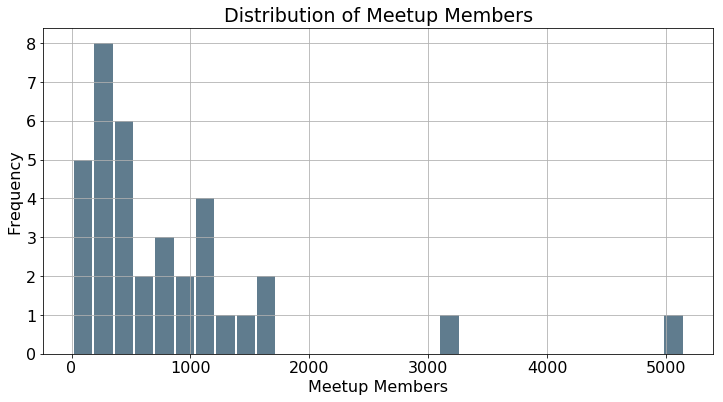

In [563]:
fig, ax = plt.subplots(figsize=(12, 6))
chapter_meetups.dropna(subset=["status"])['meetup_members'].astype('int').hist(grid=True, bins=30, rwidth=0.9, color='#607c8e', ax=ax);
ax.set_xlabel('Meetup Members'); ax.set_ylabel('Frequency');
ax.set_title('Distribution of Meetup Members');